<a href="https://colab.research.google.com/github/m3yrin/seccon2019_ws_detection/blob/master/seccon_ws_detection_m3yrin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model for 攻撃自動検知ワークショップ in SECCON 2019 

https://connpass.com/event/159753/  
seccon_ws_detection  

auther : ＠m3yrin

## Model Specification
* Char-Base CNN sequence modeling

## Memo
* Bulit on AllenNLP
* Tested on Google Colaboratory

## Preparation

In [1]:
!git clone https://github.com/palloc/seccon_ws_detection.git
!pip install allennlp

Cloning into 'seccon_ws_detection'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 1), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
     |████████████████████████████████| 7.6MB 5.0MB/s 
     |████████████████████████████████| 163kB 56.3MB/s 
     |████████████████████████████████| 194kB 43.6MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 245kB 54.0MB/s 
     |████████████████████████████████| 256kB 48.6MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 133kB 47.9MB/s 
     |████████████████████████████████| 1.0MB 55.3MB/s 
  Created wheel for numpydoc: filename=numpydoc-0.9.1-cp36-none-any.whl size=31872 sha256=489249d973a86daf876f0b51813eecf519e5a17fe7406928d72552a7ec67cb73
  Stored in directory: /root/.cache/pip/wheels/51/30/d1/92a39ba40f21cb7

In [2]:
%cd seccon_ws_detection

/content/seccon_ws_detection


In [3]:
!wget -P dataset https://raw.githubusercontent.com/palloc/seccon_ws_detection/score/dataset/level2_train.tsv

--2019-12-21 16:15:18--  https://raw.githubusercontent.com/palloc/seccon_ws_detection/score/dataset/level2_train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12683 (12K) [text/plain]
Saving to: ‘dataset/level2_train.tsv’

level2_train.tsv    100%[===================>]  12.39K  --.-KB/s    in 0s      

2019-12-21 16:15:18 (185 MB/s) - ‘dataset/level2_train.tsv’ saved [12683/12683]



In [0]:
# filepath configs
import os

full_path = './'
DATA_DIR = os.path.join(full_path, 'dataset')

#ORIGINAL_FILE = 'level1_train.tsv'
ORIGINAL_FILE = 'level2_train.tsv'
ORIGINAL_PATH = os.path.join(DATA_DIR, ORIGINAL_FILE)

TRAIN_FILE = 'level2_split_train.tsv'
TRAIN_PATH = os.path.join(DATA_DIR, TRAIN_FILE)

VALID_FILE = 'level2_split_valid.tsv'
VALID_PATH = os.path.join(DATA_DIR, VALID_FILE)

AUG_FILE = 'train_aug.tsv'
AUG_PATH = os.path.join(DATA_DIR, AUG_FILE)

## EDA

In [0]:
import codecs
import numpy as np
import pandas as pd

np.random.seed(seed=32)

In [0]:
# Load dataset.
def load_dataset(path, num_augment = None):
    dataset = []
    X = []
    y = []
    with codecs.open(path, mode='r', encoding='utf-8') as fin:
        dataset.extend(fin.readlines())
    
    for payload in dataset:
        
        
        X.append(payload.split('\t')[0])

        label = payload.split('\t')[1].replace('\n', '')
        label = int(label)
        y.append(label)


    # Data augmentation
    # sampling random 2 indices and concatinating them.
    if num_augment is not None:
        X_aug = []
        y_aug = []

        ids_list = np.random.randint(len(X), size=(num_augment, 2))

        for ids in ids_list:
            X_concat = X[ids[0]] + X[ids[1]]

            y_concat = 1 if int(y[ids[0]]) + int(y[ids[1]]) > 0 else 0

            X_aug.append(X_concat)
            y_aug.append(y_concat)
        
        # Also added original sequences
        return  X_aug + X, y_aug + y

    return X, y

In [0]:
X, y = load_dataset(ORIGINAL_PATH)
data_df = pd.DataFrame(zip(X, y))
data_df.columns = ['X','y']

In [8]:
data_df.head()

,X,y
0,From: lipman@oasys.dt.navy.mil (Robert Lipman),0
1,Subject: CALL FOR PRESENTATIONS: Navy SciViz/V...,0
2,SPONSOR: NESS (Navy Engineering Software Syste...,0
3,This computer is occurred a error on the memory.,0
4,The purpose of the seminar is to present and e...,0


In [9]:
data_df.describe()

,y
count,200.000000
mean,0.500000
std,0.501255
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


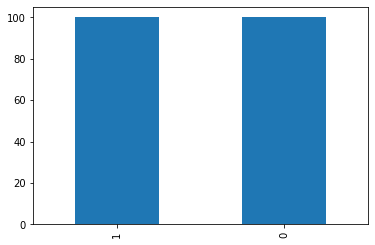

In [10]:
import matplotlib.pyplot as plt

# check the distribution of y
data_df.y.value_counts().plot(kind="bar")
plt.show()

## File Split

In [0]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=11)

In [0]:
train_df = pd.DataFrame(zip(train_X, train_y))
valid_df = pd.DataFrame(zip(valid_X, valid_y))

In [0]:
train_df.to_csv(TRAIN_PATH, sep='\t' , index=False, header=False)
valid_df.to_csv(VALID_PATH, sep='\t' , index=False, header=False)

## Data Augmentation

In [14]:
num_augment = 400
X, y = load_dataset(TRAIN_PATH, num_augment = num_augment)

data_auged_df = pd.DataFrame(zip(X, y))
data_auged_df.columns = ['X','y']
data_auged_df.head()

,X,y
0,but he claims are due to improper maintenance ...,1
1,"a Japanese style drawing room #101""<div style=...",1
2,</command>enctype=rows=<video><source onerror=...,1
3,ComputerLand franchise and another retail comp...,1
4,"""!#%&)(*+,-./:;=?@]\[^_'}|{~""""<s>""""><script>al...",1


In [15]:
data_auged_df.describe()

,y
count,560.000000
mean,0.710714
std,0.453836
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


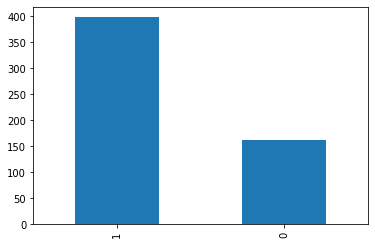

In [16]:
data_auged_df.y.value_counts().plot(kind="bar")
plt.show()

In [0]:
data_auged_df.to_csv(AUG_PATH, sep='\t' , index = False, header=False)

In [18]:
!ls dataset

level1_test.tsv   level2_split_train.tsv  level2_train.tsv
level1_train.tsv  level2_split_valid.tsv  train_aug.tsv


## Modeling

In [0]:
import numpy as np
import pandas as pd
import logging

import itertools
import json
import logging
import string
from collections import defaultdict
from typing import Dict, List, Union, Tuple, Any

from overrides import overrides
from word2number.w2n import word_to_num

import allennlp
from allennlp.common.file_utils import cached_path
from allennlp.data.fields import (
    Field,
    TextField,
    MetadataField,
    LabelField,
    ListField,
    SequenceLabelField,
    SpanField,
    IndexField,
)

from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.instance import Instance
from allennlp.data.token_indexers import SingleIdTokenIndexer, TokenIndexer
from allennlp.data.tokenizers import Token, Tokenizer

In [0]:
# logging setting
logging.basicConfig(format='%(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [0]:
class Lv1Reader(DatasetReader):

    def __init__(
        self,
        tokenizer: Tokenizer = None,
        token_indexers: Dict[str, TokenIndexer] = None,
        lazy: bool = False,
    ) -> None:
        super().__init__(lazy)
        self._tokenizer = tokenizer or WhitespaceTokenizer()
        self._token_indexers = token_indexers

    @overrides
    def _read(self, file_path: str):
        file_path = cached_path(file_path)
        
        with codecs.open(file_path, mode='r', encoding='utf-8') as dataset_file:
            for line in dataset_file:
                
                example = line.split('\t')
                payload = example[0]
                payload = self._tokenizer.tokenize(payload)

                target = None
                if len(example) == 2:
                    target = example[1].replace('\n', '')
                    target = int(target)
                
                instance = self.text_to_instance(
                    payload,
                    target,
                )
                yield instance
                

    @overrides
    def text_to_instance(
        self,  # type: ignore
        payload: str,
        target: int,
        ) -> Union[Instance, None]:
        
        fields: Dict[str, Field] = {}
        fields["payload"] = TextField(payload, self._token_indexers)

        if target is not None:
            fields["target"] = LabelField(target, skip_indexing=True)
        
        return Instance(fields)

In [0]:
from allennlp.data.tokenizers.character_tokenizer import CharacterTokenizer
from allennlp.data.token_indexers.token_characters_indexer import TokenCharactersIndexer

import os
import codecs

In [23]:
reader = Lv1Reader(tokenizer = CharacterTokenizer(),
                  token_indexers = {"token_characters": TokenCharactersIndexer(min_padding_length = 2)}
                  )

train_dataset = reader.read(AUG_PATH)
valid_dataset = reader.read(VALID_PATH)

560it [00:00, 3845.93it/s]
40it [00:00, 10010.27it/s]


In [24]:
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BasicIterator, BucketIterator

vocab = Vocabulary.from_instances(train_dataset, min_count={'token_characters': 1})
iterator = BucketIterator(
    batch_size=2,
    sorting_keys=[("payload", "num_tokens")],
)
iterator.index_with(vocab)

Fitting token dictionary from dataset.
100%|██████████| 560/560 [00:00<00:00, 4917.02it/s]


In [25]:
from allennlp.common.params import Params

char_embedding_params = Params({
    'embedding': {"embedding_dim": 64},
    'encoder': {"type": "cnn",
                "embedding_dim": 64,
                "num_filters": 100,
                "ngram_filter_sizes": [2]
               }
})

from allennlp.modules.token_embedders import Embedding,TokenCharactersEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder

char_embedding = TokenCharactersEncoder.from_params(vocab, char_embedding_params)
embedder = BasicTextFieldEmbedder({"token_characters": char_embedding})

embedding.num_embeddings = None
embedding.vocab_namespace = token_characters
embedding.embedding_dim = 64
embedding.pretrained_file = None
embedding.projection_dim = None
embedding.trainable = True
embedding.padding_index = None
embedding.max_norm = None
embedding.norm_type = 2.0
embedding.scale_grad_by_freq = False
embedding.sparse = False
instantiating class <class 'allennlp.modules.seq2vec_encoders.seq2vec_encoder.Seq2VecEncoder'> from params {'type': 'cnn', 'embedding_dim': 64, 'num_filters': 100, 'ngram_filter_sizes': [2]} and extras set()
encoder.type = cnn
instantiating class <class 'allennlp.modules.seq2vec_encoders.cnn_encoder.CnnEncoder'> from params {'embedding_dim': 64, 'num_filters': 100, 'ngram_filter_sizes': [2]} and extras set()
instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
instantiating registered subclass relu of <class 'allennlp.nn.activatio

In [0]:
from allennlp.nn.util import get_text_field_mask
from typing import Dict, Optional

from overrides import overrides
import torch

from allennlp.data import Vocabulary
from allennlp.models.model import Model
from allennlp.modules import FeedForward, Seq2SeqEncoder, Seq2VecEncoder, TextFieldEmbedder
from allennlp.nn import InitializerApplicator, RegularizerApplicator
from allennlp.nn.util import get_text_field_mask
from allennlp.training.metrics import CategoricalAccuracy

from allennlp.training.metrics.auc import Auc

class Lv1Net(Model):

    def __init__(
        self,
        vocab: Vocabulary,
        text_field_embedder: TextFieldEmbedder,
        seq2vec_encoder: Seq2VecEncoder,
        num_labels: int,
        feedforward: Optional[FeedForward] = None,
        dropout_prob: float = 0.1,
        initializer: InitializerApplicator = InitializerApplicator(),
        regularizer: Optional[RegularizerApplicator] = None,
    ) -> None:
        super().__init__(vocab, regularizer)

        self._text_field_embedder = text_field_embedder
        text_embed_dim = text_field_embedder.get_output_dim()
        self._dropout = torch.nn.Dropout(p=dropout_prob)

        self._seq2vec_encoder = seq2vec_encoder
        self._feedforward = feedforward
        self._num_labels = num_labels
        
        if feedforward is not None:
            self._classifier_input_dim = self._feedforward.get_output_dim()
        else:
            self._classifier_input_dim = self._seq2vec_encoder.get_output_dim()

        self._classification_layer = torch.nn.Linear(self._classifier_input_dim, self._num_labels)

        self._accuracy = CategoricalAccuracy()
        self._auc = Auc(positive_label = 1)
        self._loss = torch.nn.CrossEntropyLoss()


        initializer(self)
        

    def forward(  # type: ignore
        self,
        payload: Dict[str, torch.LongTensor],
        target: torch.IntTensor = None,
    ) -> Dict[str, torch.Tensor]:

        
        mask = get_text_field_mask(payload).float()


        # Shape: (batch_size, payload_length, hidden)
        embedded_text = self._text_field_embedder(payload)
        embedded_text = self._seq2vec_encoder(embedded_text, mask=mask)

        embedded_text = self._dropout(embedded_text)

        if self._feedforward is not None:
            embedded_text = self._feedforward(embedded_text)

        logits = self._classification_layer(embedded_text)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        output_dict = {"logits": logits, "probs": probs}

        if target is not None:
            loss = self._loss(logits, target.long().view(-1))
            output_dict["loss"] = loss
            self._accuracy(logits, target)
            self._auc(logits.argmax(dim=1), target)
        
        return output_dict

    @overrides
    def decode(self, output_dict: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        Does a simple argmax over the probabilities, converts index to string label, and
        add ``"label"`` key to the dictionary with the result.
        """
        predictions = output_dict["probs"]
        if predictions.dim() == 2:
            predictions_list = [predictions[i] for i in range(predictions.shape[0])]
        else:
            predictions_list = [predictions]
        classes = []
        for prediction in predictions_list:
            label_idx = prediction.argmax(dim=-1).item()
            label_str = str(label_idx)
            classes.append(label_str)
        output_dict["label"] = classes
        return output_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        #metrics = {}
        metrics = {"accuracy": self._accuracy.get_metric(reset), "auc": self._auc.get_metric(reset)}
        return metrics

In [27]:
#from allennlp.modules.seq2vec_encoders.pytorch_seq2vec_wrapper import PytorchSeq2VecWrapper
#from torch.nn import GRU
#rnn = GRU(input_size = 100, hidden_size = 64, batch_first = True, bidirectional = True)

from allennlp.modules.seq2vec_encoders.cnn_encoder import CnnEncoder
encoder = CnnEncoder(embedding_dim = 100, num_filters = 100)

instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


In [28]:
model = Lv1Net(vocab = vocab,
               text_field_embedder = embedder,
               seq2vec_encoder = encoder,
               num_labels = 2,
               dropout_prob = 0.1
               )

Initializing parameters
Done initializing parameters; the following parameters are using their default initialization from their code
   _classification_layer.bias
   _classification_layer.weight
   _seq2vec_encoder.conv_layer_0.bias
   _seq2vec_encoder.conv_layer_0.weight
   _seq2vec_encoder.conv_layer_1.bias
   _seq2vec_encoder.conv_layer_1.weight
   _seq2vec_encoder.conv_layer_2.bias
   _seq2vec_encoder.conv_layer_2.weight
   _seq2vec_encoder.conv_layer_3.bias
   _seq2vec_encoder.conv_layer_3.weight
   _text_field_embedder.token_embedder_token_characters._embedding._module.weight
   _text_field_embedder.token_embedder_token_characters._encoder._module.conv_layer_0.bias
   _text_field_embedder.token_embedder_token_characters._encoder._module.conv_layer_0.weight


In [0]:
import torch.optim as optim

LR = 1e-4
#optimizer = optim.Adam(model.parameters(), lr=LR, betas = [0.8, 0.999], eps = 1e-7 )
optimizer = optim.Adam(model.parameters(), lr=LR)

In [30]:
if torch.cuda.is_available():
    print("cuda")
    cuda_device = 0
    model = model.cuda(cuda_device)
else:
    print("cpu")
    cuda_device = -1

cuda


In [0]:
from allennlp.training.trainer import Trainer

PATIENCE = 8
EPOCHS = 100

trainer = Trainer(model = model,
                  optimizer = optimizer,
                  iterator = iterator,
                  train_dataset = train_dataset,
                  validation_dataset = valid_dataset,
                  patience = PATIENCE,
                  validation_metric = "+auc",
                  #validation_metric = "+accuracy",
                  num_epochs = EPOCHS,
                  cuda_device = cuda_device
                 )

In [32]:
trainer.train()

Beginning training.
Epoch 0/99
Peak CPU memory usage MB: 2570.516
GPU 0 memory usage MB: 713
Training
accuracy: 0.7054, auc: 0.5328, loss: 0.5860 ||: 100%|██████████| 280/280 [00:02<00:00, 114.03it/s]
Validating
accuracy: 0.3500, auc: 0.5000, loss: 0.8179 ||: 100%|██████████| 20/20 [00:00<00:00, 332.63it/s]
                    Training |  Validation
loss            |     0.586  |     0.818
cpu_memory_MB   |  2570.516  |       N/A
auc             |     0.533  |     0.500
gpu_0_memory_MB |   713.000  |       N/A
accuracy        |     0.705  |     0.350
Epoch duration: 0:00:02.588672
Estimated training time remaining: 0:04:16
Epoch 1/99
Peak CPU memory usage MB: 2594.144
GPU 0 memory usage MB: 769
Training
  0%|          | 0/280 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
accuracy: 0.7554, auc: 0.5772, loss: 0.3924 ||: 100%|█

{'best_epoch': 2,
 'best_validation_accuracy': 0.975,
 'best_validation_auc': 0.9807692307692308,
 'best_validation_loss': 0.12937733829021453,
 'epoch': 9,
 'peak_cpu_memory_MB': 2596.032,
 'peak_gpu_0_memory_MB': 769,
 'training_accuracy': 0.9982142857142857,
 'training_auc': 0.9987437185929648,
 'training_cpu_memory_MB': 2596.028,
 'training_duration': '0:00:20.266337',
 'training_epochs': 9,
 'training_gpu_0_memory_MB': 769,
 'training_loss': 0.0045888322272471015,
 'training_start_epoch': 0,
 'validation_accuracy': 0.975,
 'validation_auc': 0.9807692307692308,
 'validation_loss': 0.12396755218505859}

## Prediction (For Lv1)

In [0]:
from allennlp.predictors.predictor import Predictor

predictor = Predictor(model, reader)

In [34]:
level1_pred = []

from tqdm import tqdm

TEST_FILE = 'level1_test.tsv'
TEST_PATH = os.path.join(DATA_DIR, TEST_FILE)
test_dataset = reader.read(TEST_PATH)

for instance in tqdm(test_dataset):
    ans = predictor.predict_instance(instance)
    level1_pred.append(ans['label'])

200it [00:00, 7495.58it/s]
100%|██████████| 200/200 [00:00<00:00, 324.15it/s]


In [35]:
level1_pred_df = pd.DataFrame(level1_pred)
level1_pred_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,1,0,1,0,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,...,0,0,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,0,0,0


In [0]:
level1_pred_df.T.to_csv('level1_pred.csv', index = False, header=False)

In [0]:
from google.colab import files
files.download('level1_pred.csv')